<a href="https://colab.research.google.com/github/dmitr2ish/MOMO_2023/blob/main/%D0%91%D0%B8%D0%B1%D0%BB%D0%B8%D0%BE%D1%82%D0%B5%D0%BA%D0%B0_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Цель Блокнота

Знакомство с предварительной обработкой данных в библиотеке Scikit-learn
* Предварительная обработка числовых и категориальных признаков
* Написание собственных классов для предварительной обработки
* Особенности работы с Pipeline

# Import библиотек

In [ ]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего

# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler# Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder# Импортируем Порядковое кодированиеот scikit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Набор данных



Набор данных представляет собой статистику параметров автомобилей на вторичном рынке в Молдавии.

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный параметр.

Среди указанных параметров приведены целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди параметров есть целевой для задачи классификации - тип трансмиссии.

 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий параметр).

# Загружаем данные в Pandas

Загружаем наши данные из файла по прямой ссылке на git-hub

In [ ]:
DF = pd.read_csv('https://raw.githubusercontent.com/dayekb/mpti_ml/main/data/cars_moldova_clean.csv', delimiter = ',')
DF

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
...,...,...,...,...,...,...,...,...,...
32480,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0
32481,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
32482,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
32483,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


# Работа с данными

### Посчитаем число численных и категориальных колонок

In [ ]:
cat_columns = []
num_columns = []

for column_name in DF.columns:
    if (DF[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))



categorical columns:	  ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission'] 
 len =  5
numerical columns:	  ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)'] 
 len =  4


# Предварительная обработка числовых признаков

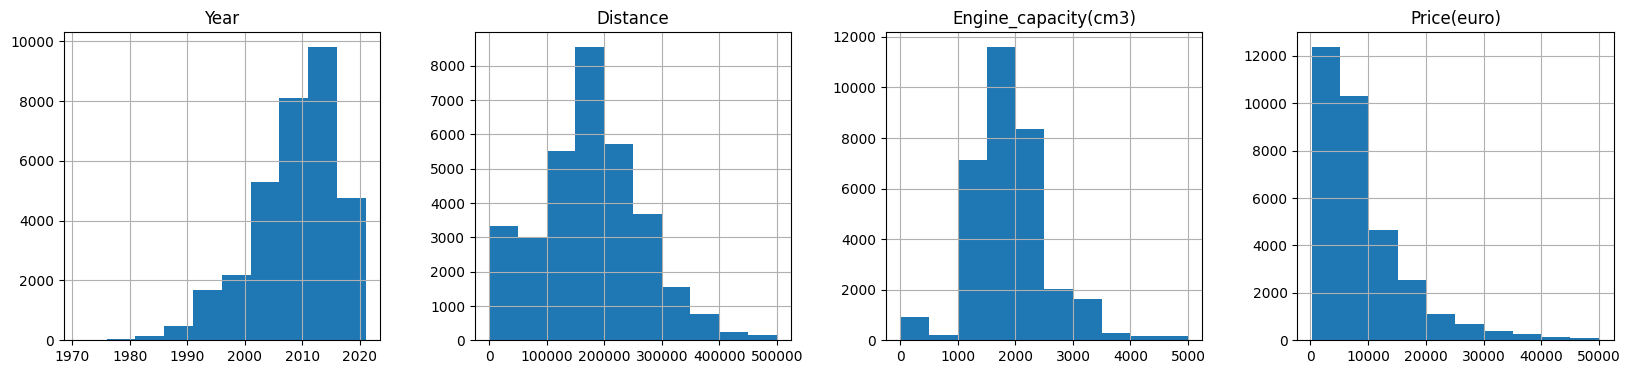

In [ ]:
fig, axs = plt.subplots(1,4,figsize=(20,  4))# создаем "полотно", на котором будем "рисовать" графики
#     ↑  более точная структура (почти синоним subplot). Говорим что у нас будет 1 строка и 4 столбца

DF.hist(column = num_columns, ax = axs );

Делаем вывод о том, что `Distance` и `Engine_Capacity` условно нормальные (хотя в `Distance`  можно и подрезать редкие значения), их можно просто нормировать / стандартизировать

`Year` и `Price` лучше нелинейно преобразовывать

## Стандартизация

$$ x' =\frac{x - mean(x)}{std(x)}$$

### **Первый шаг**

создаем объект `StandardScaler()` и "обучаем" его `.fit`

Где мы сохраняем среднее значение (`mean_`) и стандартное отклонение (`scale_`) исходного набора данных

Это полезно, так как вы можете использовать те же значения для других данных в будущем

In [ ]:
scale = StandardScaler()

scale.fit(DF[num_columns]);

Можно посмотреть на среднее и ско

In [ ]:
scale.mean_, scale.scale_

(array([  2008.22296445, 179214.51192858,   1834.5473911 ,   8962.55853471]),
 array([7.21274177e+00, 9.15535455e+04, 6.25227108e+02, 7.83935073e+03]))

### **Шаг второй**

применяем трансформацию `.transform`

И пакуем результат в Dataframe

In [ ]:
scaled = scale.transform(DF[num_columns])
df_standard = pd.DataFrame(scaled, columns= num_columns)
df_standard

,Year,Distance,Engine_capacity(cm3),Price(euro)
0,0.385018,0.172418,-0.055256,-0.154676
1,0.800949,-0.482936,-0.535081,-0.052627
2,0.523662,-0.756000,-0.535081,-0.307750
3,-0.308200,0.227031,-0.375140,-0.620276
4,-1.140061,1.319288,0.584512,-0.698088
...,...,...,...,...
32480,1.078236,-0.996297,-0.055256,0.323680
32481,-0.862774,0.500095,-0.055256,-0.582007
32482,0.939592,-0.985374,-0.535081,-0.250347
32483,-0.308200,2.083868,0.264628,-0.633032


Визуализируем

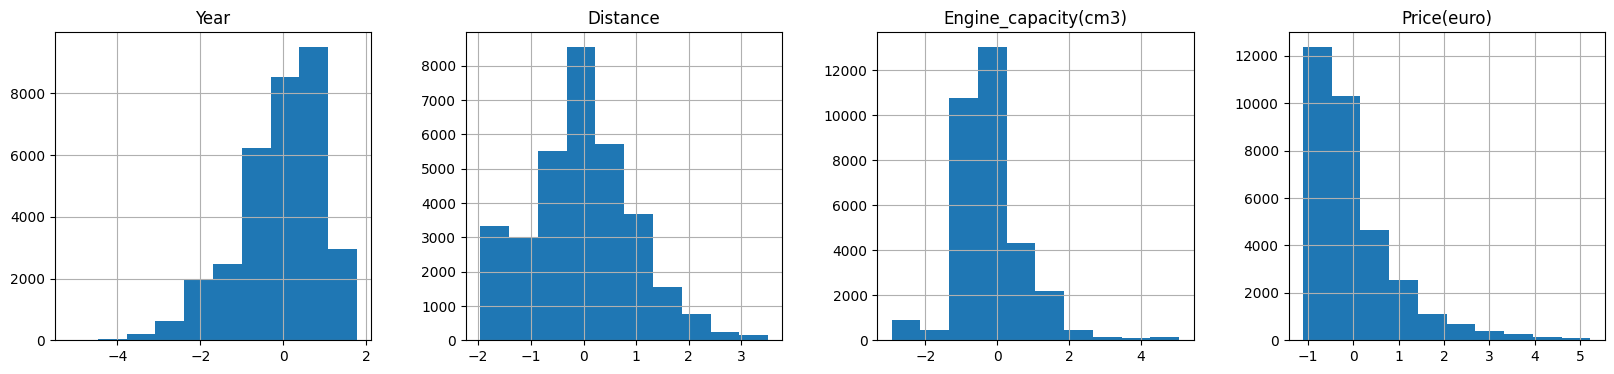

In [ ]:
df_standard.hist(figsize = (20,4), layout= (1,4));

## Нормализация

$$ x' =\frac{x - \min(x)}{\max(x) - \min(x)}$$

### **Первый шаг**

создаем объект `MinMaxScaler()` и "обучаем" его `.fit`

Где мы сохраняем максимальное (`data_max_`) и минимальное (`data_min_`) исходного набора данных

Это полезно, так как вы можете использовать те же значения для других данных в будущем

In [ ]:
norm = MinMaxScaler()

norm.fit(DF[num_columns]);

Можно посмотреть на максимальное и минимальное значения для каждого из принаков

In [ ]:
norm.data_max_, norm.data_min_

(array([  2021., 500000.,   5000.,  50000.]),
 array([1.971e+03, 1.000e+00, 0.000e+00, 2.000e+02]))

### **Шаг второй**

применяем трансформацию `.transform`

И пакуем результат в Dataframe

In [ ]:
normolized = norm.transform(DF[num_columns])
df_norm = pd.DataFrame(normolized, columns= num_columns)
df_norm

,Year,Distance,Engine_capacity(cm3),Price(euro)
0,0.80,0.389999,0.36,0.151606
1,0.86,0.269999,0.30,0.167671
2,0.82,0.219998,0.30,0.127510
3,0.70,0.399999,0.32,0.078313
4,0.58,0.599999,0.44,0.066064
...,...,...,...,...
32480,0.90,0.175998,0.36,0.226908
32481,0.62,0.449999,0.36,0.084337
32482,0.88,0.177998,0.30,0.136546
32483,0.70,0.739999,0.40,0.076305


Визуализируем

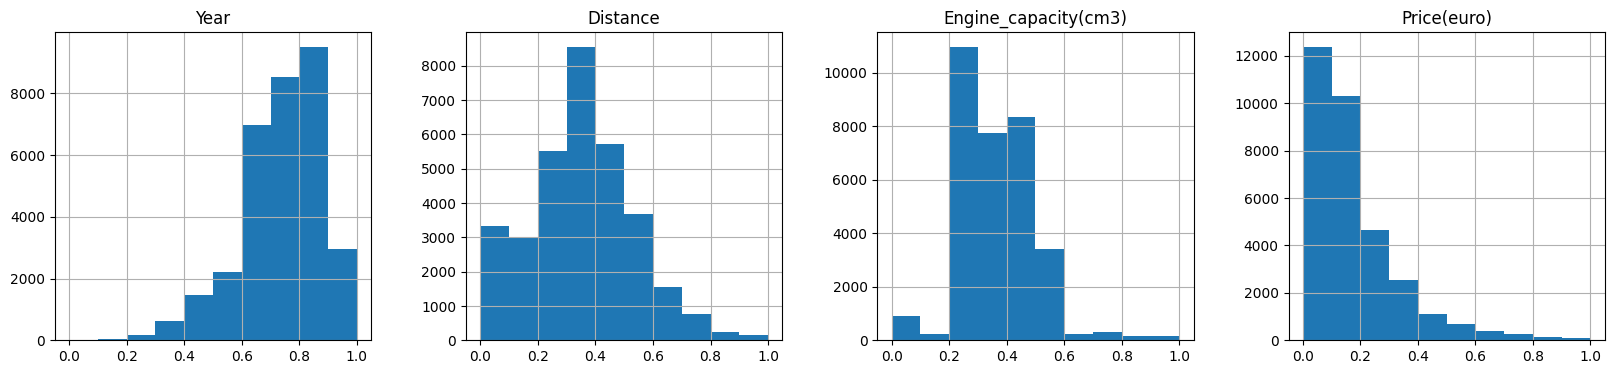

In [ ]:
df_norm.hist(figsize = (20,4), layout= (1,4));

## Степенное преобразование

### **Первый шаг**

Создание Объекта `PowerTransformer()` и его "обучение" `.fit`


In [ ]:
pt = PowerTransformer()

pt.fit(DF[num_columns]);

Коэффициенты степени преобразования

In [ ]:
pt.lambdas_

array([46.72708893,  0.77535509,  0.83165988,  0.13975694])

### **Шаг второй**

применяем трансформацию `.transform`

И пакуем результат в Dataframe

In [ ]:
power = pt.transform(DF[num_columns])
df_power = pd.DataFrame(power, columns= num_columns)
df_power

,Year,Distance,Engine_capacity(cm3),Price(euro)
0,0.337261,0.231356,-0.023831,0.180634
1,0.822301,-0.413023,-0.508385,0.296374
2,0.495283,-0.699791,-0.508385,-0.013909
3,-0.401125,0.282850,-0.345198,-0.532149
4,-1.183001,1.261423,0.601702,-0.702638
...,...,...,...,...
32480,1.164504,-0.964538,-0.023831,0.655393
32481,-0.934177,0.536159,-0.023831,-0.456188
32482,0.991462,-0.952204,-0.508385,0.062383
32483,-0.401125,1.901967,0.291571,-0.558533


Визуализируем

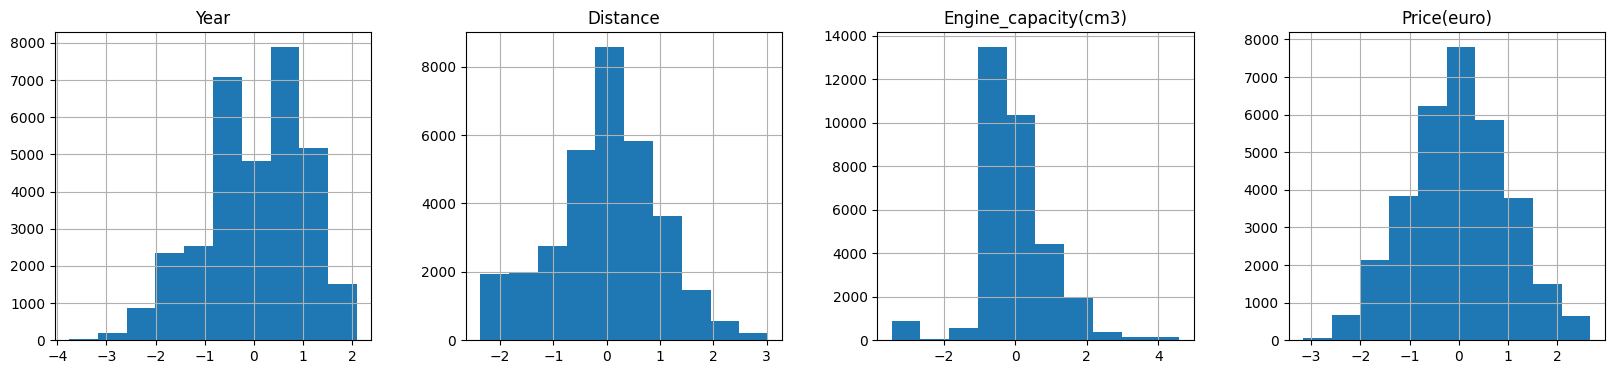

In [ ]:
df_power.hist(figsize = (20,4), layout= (1,4));

## Давайте создадим заменятель редких значений

Посмотрим на статистику числовых признаков

In [ ]:
DF.describe()

,Year,Distance,Engine_capacity(cm3),Price(euro)
count,32485.000000,32485.000000,32485.000000,32485.000000
mean,2008.222964,179214.511929,1834.547391,8962.558535
std,7.212853,91554.954674,625.236731,7839.471389
min,1971.000000,1.000000,0.000000,200.000000
25%,2004.000000,122000.000000,1497.000000,3500.000000
50%,2009.000000,180000.000000,1800.000000,6690.000000
75%,2014.000000,235000.000000,2000.000000,11999.000000
max,2021.000000,500000.000000,5000.000000,50000.000000


Эта реализация определяет класс `QuantileReplacer`, который наследуется от классов `BaseEstimator` и `TransformerMixin` из scikit-learn. Класс принимает параметр `threshold`, который определяет относительное пороговое значение для идентификации редких числовых значений.

Метод `fit` вычисляет нижний и верхний квантили для каждого числового признака во входном фрейме данных pandas и сохраняет их в словаре.

Метод `transform` заменяет редкие числовые значения значениями, основанными на квантилях, хранящихся в словаре.

Если редкое значение выше, чем среднее значение нижнего и верхнего квантилей, оно заменяется значением высокого квантиля. В противном случае оно заменяется значением нижнего квантиля.

In [ ]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

Применение - стандартная рутина

* Создаем объект класса
* "Обучаем" через `.fit`
* Применяем через `.transform`

In [ ]:
qr = QuantileReplacer(threshold=0.01, )

qr.fit(DF[num_columns])

DF_num_rare = qr.transform(DF[num_columns])

Посмотрим на новую статистику числовых признаков

In [ ]:
DF_num_rare.describe()

,Year,Distance,Engine_capacity(cm3),Price(euro)
count,32485.000000,32485.000000,32485.000000,32485.000000
mean,2008.002001,182874.742558,1865.995783,9267.968170
std,7.220145,91636.112348,607.243664,8099.445513
min,1988.000000,2222.000000,111.000000,650.000000
25%,2004.000000,123456.000000,1500.000000,3650.000000
50%,2009.000000,180000.000000,1800.000000,6800.000000
75%,2014.000000,240000.000000,2000.000000,12290.000000
max,2019.000000,415000.000000,3816.000000,39000.000000


# Предварительная обработка категориальных признаков

## Порядковое кодирование

### **Первый шаг**

Создание Объекта `OrdinalEncoder()` и его "обучение" `.fit`

In [ ]:
ordinal = OrdinalEncoder()
ordinal.fit(DF[cat_columns]);

Можно посмотреть на какие категории что значат

In [ ]:
ordinal.categories_

[array(['Alfa Romeo', 'Alta marca', 'Audi', 'BMW', 'Cadillac', 'Chevrolet',
        'Chrysler', 'Citroen', 'Dacia', 'Daewoo', 'Daihatsu', 'Dodge',
        'Fiat', 'Ford', 'GAZ', 'Honda', 'Hyundai', 'Infiniti', 'Jaguar',
        'Jeep', 'KIA', 'Land Rover', 'Lexus', 'Lincoln', 'Mazda',
        'Mercedes', 'Mini', 'Mitsubishi', 'Moskvich / Izh', 'Nissan',
        'Opel', 'Peugeot', 'Porsche', 'Rare', 'Renault', 'Rover', 'Seat',
        'Skoda', 'Smart', 'Ssangyong', 'Subaru', 'Suzuki', 'Tesla',
        'Toyota', 'UAZ', 'Vaz', 'Volkswagen', 'Volvo'], dtype=object),
 array(['1 Series', '100', '1007', '106', '107', '108', '1102 Tavria',
        '121', '147', '156', '159', '166', '19', '190', '2', '2 Series',
        '200 Series', '2008', '205', '206', '207', '208', '21', '2101',
        '2102', '2103', '2104', '2105', '2106', '2107', '2108', '2109',
        '21099', '2110', '2111', '2112', '2113', '2114', '2115',
        '2121niva', '2125', '2129 Niva Long', '2140', '2141', '2410', '25',
  

### **Шаг второй**

применяем трансформацию `.transform`

И пакуем результат в Dataframe

In [ ]:
Ordinal_encoded = ordinal.transform(DF[cat_columns])
df_ordinal = pd.DataFrame(Ordinal_encoded, columns = cat_columns)
df_ordinal

,Make,Model,Style,Fuel_type,Transmission
0,43.0,542.0,4.0,2.0,0.0
1,34.0,364.0,11.0,0.0,1.0
2,34.0,425.0,11.0,0.0,1.0
3,30.0,138.0,11.0,3.0,1.0
4,25.0,729.0,5.0,0.0,1.0
...,...,...,...,...,...
32480,46.0,518.0,10.0,4.0,0.0
32481,21.0,328.0,3.0,3.0,1.0
32482,8.0,438.0,11.0,0.0,1.0
32483,24.0,78.0,1.0,0.0,1.0


## One-hot кодирование многозначных признаков

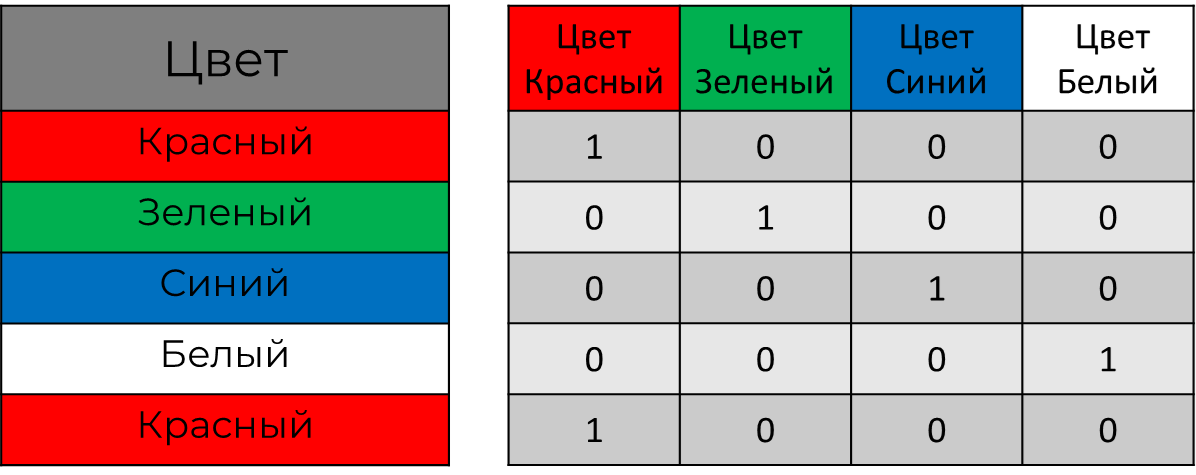

### **Первый шаг**

Создание Объекта `OneHotEncoder()` и его "обучение" `.fit`

In [ ]:
ohe = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False)
ohe.fit(DF[cat_columns]);

Смотрим где какие категории

In [ ]:
ohe.categories_

[array(['Alfa Romeo', 'Alta marca', 'Audi', 'BMW', 'Cadillac', 'Chevrolet',
        'Chrysler', 'Citroen', 'Dacia', 'Daewoo', 'Daihatsu', 'Dodge',
        'Fiat', 'Ford', 'GAZ', 'Honda', 'Hyundai', 'Infiniti', 'Jaguar',
        'Jeep', 'KIA', 'Land Rover', 'Lexus', 'Lincoln', 'Mazda',
        'Mercedes', 'Mini', 'Mitsubishi', 'Moskvich / Izh', 'Nissan',
        'Opel', 'Peugeot', 'Porsche', 'Rare', 'Renault', 'Rover', 'Seat',
        'Skoda', 'Smart', 'Ssangyong', 'Subaru', 'Suzuki', 'Tesla',
        'Toyota', 'UAZ', 'Vaz', 'Volkswagen', 'Volvo'], dtype=object),
 array(['1 Series', '100', '1007', '106', '107', '108', '1102 Tavria',
        '121', '147', '156', '159', '166', '19', '190', '2', '2 Series',
        '200 Series', '2008', '205', '206', '207', '208', '21', '2101',
        '2102', '2103', '2104', '2105', '2106', '2107', '2108', '2109',
        '21099', '2110', '2111', '2112', '2113', '2114', '2115',
        '2121niva', '2125', '2129 Niva Long', '2140', '2141', '2410', '25',
  

### **Шаг второй**

применяем трансформацию `.transform`

И пакуем результат в Dataframe

In [ ]:
ohe_feat = ohe.transform(DF[cat_columns])
#                                       ↓с помощью метода получаем полные имена One-Hot кодировки
df_ohe = pd.DataFrame(ohe_feat, columns = ohe.get_feature_names_out()).astype(int)

df_ohe

,Make_Alfa Romeo,Make_Alta marca,Make_Audi,Make_BMW,Make_Cadillac,Make_Chevrolet,Make_Chrysler,Make_Citroen,Make_Dacia,Make_Daewoo,...,Style_SUV,Style_Sedan,Style_Universal,Fuel_type_Diesel,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid,Transmission_Manual
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32480,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
32481,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
32482,0,0,0,0,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,1
32483,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


## Напишем заменятель редких категориальных данных

посмотрим на число повторений результата в каждом категориальном признаке

In [ ]:
DF[cat_columns].nunique()

Make             48
Model           781
Style            12
Fuel_type         6
Transmission      2
dtype: int64

Класс `RareGrouper` наследуется от классов `BaseEstimator` и `TransformerMixin` из sklearn.

Метод `fit` вычисляет относительную частоту категориальных признаков во входном DataFrame и сохраняет их в словаре.

Метод `transform` заменяет редкие категориальные признаки на строку `other_value`, указанную во время инициализации.

In [ ]:
class RareGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05, other_value='Other'):
        self.threshold = threshold
        self.other_value = other_value
        self.freq_dict = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']):
            freq = X[col].value_counts(normalize=True)
            self.freq_dict[col] = freq[freq >= self.threshold].index.tolist()
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in X.select_dtypes(include=['object']):
            X_copy[col] = X_copy[col].apply(lambda x: x if x in self.freq_dict[col] else self.other_value)
        return X_copy

Применение - стандартная рутина

* Создаем объект класса
* "Обучаем" через `.fit`
* Применяем через `.transform`

В этой реализации мы объединили обучение и применение через метод `.fit_transform`

In [ ]:
rg = RareGrouper(threshold=0.001, other_value='rare')
DF_cat_rare = rg.fit_transform(DF[cat_columns])
DF_cat_rare

,Make,Model,Style,Fuel_type,Transmission
0,Toyota,Prius,Hatchback,Hybrid,Automatic
1,Renault,Grand Scenic,Universal,Diesel,Manual
2,Renault,Laguna,Universal,Diesel,Manual
3,Opel,Astra,Universal,Metan/Propan,Manual
4,Mercedes,Vito,Microvan,Diesel,Manual
...,...,...,...,...,...
32480,Volkswagen,Passat,Sedan,Petrol,Automatic
32481,Land Rover,Freelander,Crossover,Metan/Propan,Manual
32482,Dacia,Logan Mcv,Universal,Diesel,Manual
32483,Mazda,6,Combi,Diesel,Manual


посмотрим на число повторений результата в каждом категориальном признаке после замены

In [ ]:
DF_cat_rare.nunique()

Make             41
Model           179
Style            12
Fuel_type         6
Transmission      2
dtype: int64

# Pipeline

Создаем объект `Pipeline`

На вход ему подаем список из того, что мы хотим объединить в формате
* строка- название (даем имя Объекту)
* и сам объект (с заданными аргументами, если необходимо)

создадим отдельно `Pipeline` для разных признаков

### Для Distance

Заменяем редкие значения и стандартизируем

In [ ]:
num_pipe_distance = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('scaler', StandardScaler())
])

num_distance = ['Distance']

### Для Engine_capacity(cm3)

Просто Стандартизируем

In [ ]:
num_pipe_engine = Pipeline([
    ('scaler', StandardScaler())
])

num_engine = ['Engine_capacity(cm3)']

### Для Year и Price(euro)

Заменяем степенное преобразование

In [ ]:
num_pipe_year_price = Pipeline([
    ('power', PowerTransformer())
])

num_year_price = ['Year','Price(euro)']

### Для Transmission

Достаточно порядкового кодирования

In [ ]:
cat_pipe_transmission = Pipeline([
    ('encoder', OrdinalEncoder())

])

cat_transmission = ['Transmission']

### Для Style и Fuel_type

Выполняем one-hot кодирование

In [ ]:
cat_pipe_style_fuel = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))

])

cat_style_fuel = ['Style', 'Fuel_type']

### Для Make

Делаем замену редких и one-hot кодирование

In [ ]:
cat_pipe_make = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_make = ['Make']

### Для Model

Делаем замену редких (но с другим порогом) и one-hot кодирование

In [ ]:
cat_pipe_model = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.0001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_model = ['Model']

## Объединяем в единый Трансформер Колонок Данных

Класс `ColumnTransformer` имеет в целом схожий синтаксис с `Pipeline`

т.е. на вход ему также подаем список из того, что мы хотим объединить в формате

* строка- название (даем имя Объекту)
* сам объект (в этом случае подаем объекты Pipeline)
* добавляется еще список названий столбцов, к которым мы применяем эти преобразования


In [ ]:
preprocessors = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year_price', num_pipe_year_price, num_year_price),
    ('cat_transmission', cat_pipe_transmission, cat_transmission),
    ('cat_style_fuel', cat_pipe_style_fuel, cat_style_fuel),
    ('cat_make', cat_pipe_make, cat_make),
    ('cat_model', cat_pipe_model, cat_model),
])

In [ ]:
preprocessors

ColumnTransformer(transformers=[('num_distance',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold=0.01)),
                                                 ('scaler', StandardScaler())]),
                                 ['Distance']),
                                ('num_engine',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Engine_capacity(cm3)']),
                                ('num_year_price',
                                 Pipeline(steps=[('power',
                                                  PowerTransformer())]),
                                 ['Year', 'Price(euro)']),
                                ('cat_transmissio...
                                ('cat_make',
                                 Pipeline(steps=[('replace_rare',
                                                  RareGrouper(threshold=0.001)),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Make']),
                                ('cat_model',
                                 Pipeline(steps=[('replace_rare',
                                                  RareGrouper(threshold=0.0001)),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Model'])])

"Обучаем" стандартно через `.fit()`

Тут важно, что на вход мы подаем датафреймы, т.к. в них есть колонки к которым мы обращаемся "по именам".

Внимательно следите за названиями колонок, он проверяет всё добуквенно

In [ ]:
preprocessors.fit(DF);

### Про то, как оттуда извлекать имена признаков из pipeline

это можно делать ПОСЛЕ того как сделан `.fit()`


**Шаг 1**

спускаемся на уровень трансформеров

In [ ]:
preprocessors.transformers_

[('num_distance',
  Pipeline(steps=[('QuantReplace', QuantileReplacer(threshold=0.01)),
                  ('scaler', StandardScaler())]),
  ['Distance']),
 ('num_engine',
  Pipeline(steps=[('scaler', StandardScaler())]),
  ['Engine_capacity(cm3)']),
 ('num_year_price',
  Pipeline(steps=[('power', PowerTransformer())]),
  ['Year', 'Price(euro)']),
 ('cat_transmission',
  Pipeline(steps=[('encoder', OrdinalEncoder())]),
  ['Transmission']),
 ('cat_style_fuel',
  Pipeline(steps=[('encoder',
                   OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                                 sparse_output=False))]),
  ['Style', 'Fuel_type']),
 ('cat_make',
  Pipeline(steps=[('replace_rare', RareGrouper(threshold=0.001)),
                  ('encoder',
                   OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                                 sparse_output=False))]),
  ['Make']),
 ('cat_model',
  Pipeline(steps=[('replace_rare', RareGrouper(threshold=0.0001)),
       

**Шаг 2**

выбираем нужный трансформер (с индексом 4)

In [ ]:
preprocessors.transformers_[4]

('cat_style_fuel',
 Pipeline(steps=[('encoder',
                  OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                                sparse_output=False))]),
 ['Style', 'Fuel_type'])

**Шаг 3**

Берем Pipeline (индекс 1, под индексом 0 - название)

In [ ]:
preprocessors.transformers_[4][0]

'cat_style_fuel'

In [ ]:
preprocessors.transformers_[4][1]

Pipeline(steps=[('encoder',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                               sparse_output=False))])

**Шаг 4**

обращаемся к Pipeline "по имени" (потому что это уже не список, а словарь)

In [ ]:
preprocessors.transformers_[4][1]['encoder']

OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

**Шаг 5**  

применяем то же метод `.get_feature_names_out` что и раньше

In [ ]:
preprocessors.transformers_[4][1]['encoder'].get_feature_names_out(cat_style_fuel)

array(['Style_Cabriolet', 'Style_Combi', 'Style_Coupe', 'Style_Crossover',
       'Style_Hatchback', 'Style_Microvan', 'Style_Minivan',
       'Style_Pickup', 'Style_Roadster', 'Style_SUV', 'Style_Sedan',
       'Style_Universal', 'Fuel_type_Diesel', 'Fuel_type_Electric',
       'Fuel_type_Hybrid', 'Fuel_type_Metan/Propan', 'Fuel_type_Petrol',
       'Fuel_type_Plug-in Hybrid'], dtype=object)

Повторим это для всех категориальных признаков с one-hot кодированием

In [ ]:
cat_style_fuel_names = preprocessors.transformers_[4][1]['encoder'].get_feature_names_out(cat_style_fuel)
cat_make_names =  preprocessors.transformers_[5][1]['encoder'].get_feature_names_out(cat_make)
cat_model_names =  preprocessors.transformers_[6][1]['encoder'].get_feature_names_out(cat_model)

# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns = np.hstack([num_distance,
                    num_engine,
                    num_year_price,
                    cat_transmission,
                    cat_style_fuel_names,
                    cat_make_names,
                    cat_model_names])

In [ ]:
DF_transformed = preprocessors.transform(DF)
pd.DataFrame(DF_transformed, columns=columns)

,Distance,Engine_capacity(cm3),Year,Price(euro),Transmission,Style_Cabriolet,Style_Combi,Style_Coupe,Style_Crossover,Style_Hatchback,...,Model_ZOE,Model_Zafira,Model_i10,Model_i20,Model_i3,Model_i30,Model_i40,Model_iQ,Model_ix20,Model_ix35
0,0.132322,-0.055256,0.337261,0.180634,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.522452,-0.535081,0.822301,0.296374,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.795275,-0.535081,0.495283,-0.013909,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.186886,-0.375140,-0.401125,-0.532149,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.278176,0.584512,-1.183001,-0.702638,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32480,-1.035358,-0.055256,1.164504,0.655393,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32481,0.459709,-0.055256,-0.934177,-0.456188,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32482,-1.024445,-0.535081,0.991462,0.062383,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32483,2.042079,0.264628,-0.401125,-0.558533,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
